<a href="https://colab.research.google.com/github/Sudipta-Trisha/Deepfake-Audio-Detection/blob/main/Deepfake_Audio_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/drive/Shareddrives/Brain Analysis/Deepfake Audio Detection/LA.zip"

Streaming output truncated to the last 5000 lines.
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7787040.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_2924301.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9249366.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_3442936.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7772915.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_5569336.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7773607.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7813281.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9705954.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_2427464.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1000273.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_5263550.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1642109.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1339848.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9495857.flac  
  inflating: LA/ASV

###Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import csv
import soundfile as sf
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from shutil import copy

import tensorflow as tf
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [3]:
audio_data = pd.read_csv("/content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt", sep = " ", names = ('Id','Filename','a','FakeType','Class'))
audio_data

,Id,Filename,a,FakeType,Class
0,LA_0039,LA_E_2834763,-,A11,spoof
1,LA_0014,LA_E_8877452,-,A14,spoof
2,LA_0040,LA_E_6828287,-,A16,spoof
3,LA_0022,LA_E_6977360,-,A09,spoof
4,LA_0031,LA_E_5932896,-,A13,spoof
...,...,...,...,...,...
71232,LA_0004,LA_E_1665632,-,-,bonafide
71233,LA_0038,LA_E_5085671,-,A09,spoof
71234,LA_0012,LA_E_4926022,-,A16,spoof
71235,LA_0052,LA_E_2894498,-,-,bonafide


In [4]:
audio_data['Class'].value_counts()

spoof       63882
bonafide     7355
Name: Class, dtype: int64

In [5]:
audio_data_frame = audio_data[audio_data['FakeType'] == '-']
audio_data_frame.shape

(7355, 5)

In [10]:
# Here 'Human_voice' folder consist all real voice data

Path('AudioData/Human_voice').mkdir(parents = True ,exist_ok = True)
real_voice = audio_data_frame['Filename']

for file in real_voice:
  fileName = os.path.join('/content/LA/ASVspoof2019_LA_eval/flac/',file +'.flac')
  if os.path.isfile(fileName):
    copy(fileName,'AudioData/Human_voice')


In [ ]:
print(len(os.listdir('/content/AudioData/Human_voice')))

In [ ]:
!unrar x '/content/drive/Shareddrives/Brain Analysis/Deepfake Audio Detection/Generated_voice.rar'

###Feature Extraction

***For Real data***

In [15]:
from tqdm import tqdm
import os.path

def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

extracted_audio_features=[]
for index_num,row in tqdm(audio_data.iterrows()):
    file_name = os.path.join(os.path.abspath('/content/AudioData/Human_voice'),str(row["Filename"]) +'.flac')
    file_exists = os.path.exists(file_name)

    if file_exists:
      final_class_labels=row["Class"]
      data=features_extractor(file_name)
      extracted_audio_features.append([data,final_class_labels])
    else:
      continue

71237it [05:42, 208.16it/s]


In [16]:
extracted_audio_features_df=pd.DataFrame(extracted_audio_features,columns=['feature','class'])
extracted_audio_features_df.head(10)

,feature,class
0,"[-353.57852, 117.506546, 6.1897874, 46.301567,...",bonafide
1,"[-338.22507, 78.90081, -28.387444, 37.21896, -...",bonafide
2,"[-354.2305, 91.87845, -16.014444, 35.25228, -1...",bonafide
3,"[-398.7425, 81.02405, -22.985292, 20.719105, -...",bonafide
4,"[-410.0659, 84.023506, -2.7711487, 26.244364, ...",bonafide
5,"[-394.27267, 75.53885, -19.248583, 20.347034, ...",bonafide
6,"[-312.2722, 109.156555, -12.196954, 32.039555,...",bonafide
7,"[-312.64236, 120.73407, -5.2511587, 26.283012,...",bonafide
8,"[-361.91632, 83.927826, -15.413995, 34.923546,...",bonafide
9,"[-289.36295, 112.63236, -44.577618, 31.302942,...",bonafide


***For fake data***

In [17]:
from tqdm import tqdm
import os.path

def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

for index_num,row in tqdm(audio_data.iterrows()):
    file_name = os.path.join(os.path.abspath('/content/AudioData/Generated_voice'),str(row["Filename"]) +'.flac')
    file_exists = os.path.exists(file_name)

    if file_exists:
      final_class_labels=row["Class"]
      data=features_extractor(file_name)
      extracted_audio_features.append([data,final_class_labels])
    else:
      continue

71237it [05:00, 237.28it/s]


In [18]:
len(extracted_audio_features)

14638

In [19]:
extracted_audio_features_df=pd.DataFrame(extracted_audio_features,columns=['feature','class'])
extracted_audio_features_df

,feature,class
0,"[-353.57852, 117.506546, 6.1897874, 46.301567,...",bonafide
1,"[-338.22507, 78.90081, -28.387444, 37.21896, -...",bonafide
2,"[-354.2305, 91.87845, -16.014444, 35.25228, -1...",bonafide
3,"[-398.7425, 81.02405, -22.985292, 20.719105, -...",bonafide
4,"[-410.0659, 84.023506, -2.7711487, 26.244364, ...",bonafide
...,...,...
14633,"[-330.0263, 101.42687, -12.65303, 54.05666, 3....",spoof
14634,"[-279.4167, 116.62783, 16.772135, 59.709366, -...",spoof
14635,"[-325.74307, 97.257225, -29.123882, 34.492405,...",spoof
14636,"[-252.96123, 101.68595, -53.129494, 42.94996, ...",spoof


***Converting list into csv file***

In [20]:
extracted_audio_features_df.to_csv(r'/content/Extracted_Features.csv', index=False)

##Data Splitting

In [21]:
X=np.array(extracted_audio_features_df['feature'].tolist())
y=np.array(extracted_audio_features_df['class'].tolist())

In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11710, 40)
(2928, 40)
(11710, 2)
(2928, 2)


In [25]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=0)

In [26]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(9368, 40)
(2342, 40)
(9368, 2)
(2342, 2)


###Creating Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model

In [28]:
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(learning_rate=0.001)

In [29]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [30]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [31]:
earlystop = EarlyStopping(patience=10)
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                patience = 2,
                                verbose = 1,
                                factor = 0.5,
                                min_lr = 0.001
)

In [32]:
callbacks = [earlystop,lr_reduction]

In [33]:
num_epochs = 20
num_batch_size = 32

# save the model
keras_file = "Detection_Model3.h5"
tf.keras.models.save_model(model,keras_file)


In [34]:
history = model.fit(X_train,
          y_train,
          batch_size=num_batch_size,
          epochs=num_epochs,
          validation_data=(X_val, y_val),
          callbacks=callbacks,
          verbose=1)

Epoch 1/20
293/293 [==============================] - 2s 3ms/step - loss: 0.8218 - accuracy: 0.6086 - val_loss: 0.4007 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 2/20
293/293 [==============================] - 1s 3ms/step - loss: 0.4673 - accuracy: 0.7949 - val_loss: 0.3796 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 3/20
293/293 [==============================] - 1s 3ms/step - loss: 0.4127 - accuracy: 0.8352 - val_loss: 0.3706 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 4/20
293/293 [==============================] - 1s 3ms/step - loss: 0.3938 - accuracy: 0.8450 - val_loss: 0.3674 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 5/20
293/293 [==============================] - 1s 3ms/step - loss: 0.3811 - accuracy: 0.8508 - val_loss: 0.3608 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 6/20
293/293 [==============================] - 1s 3ms/step - loss: 0.3780 - accuracy: 0.8491 - val_loss: 0.3546 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 7/20
293/293 [==============================] - 1s 3ms/step - lo

##Data Loss and Accuracy visualization

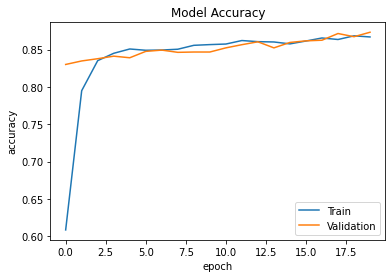

In [35]:
'''Plot a graph for Training accuracy and validation accuracy'''

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

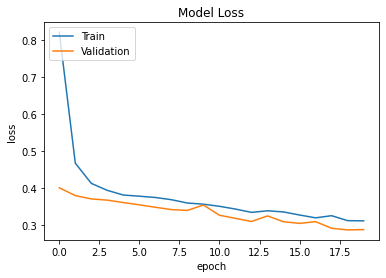

In [36]:
'''Plot a graph for Training loss and validation loss'''

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

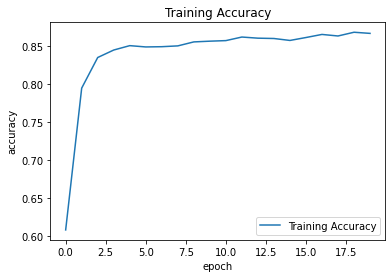

In [37]:
'''Plot a graph for Training Accuracy'''
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy'], loc='lower right')
plt.show()

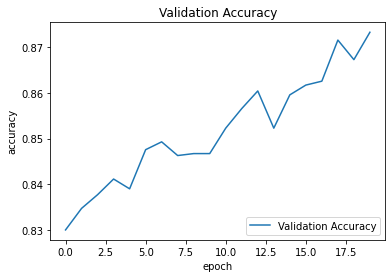

In [38]:
'''Plot a graph for Validation Accuracy'''

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Validation Accuracy'], loc='lower right')
plt.show()

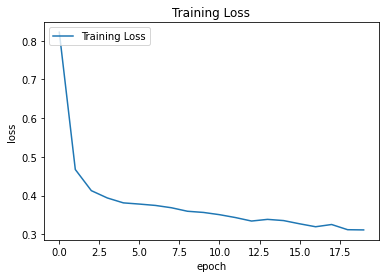

In [39]:
'''Plot a graph for Training Loss'''

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss'], loc='upper left')
plt.show()

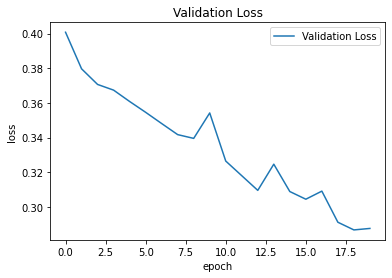

In [40]:
'''Plot a graph for Validation Loss'''

plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Validation Loss'], loc='upper right')
plt.show()

##Model Prediction

In [41]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print('Accuracy = ',test_accuracy[1])
print('Loss = ',test_accuracy[0])

Accuracy =  0.880806028842926
Loss =  0.28009387850761414


##Testing the model

In [42]:
audio_file = '/content/LA_T_6099596.flac'

In [43]:
audio, sample_rate = librosa.load(audio_file, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [44]:
print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

[-2.96796936e+02  1.30487442e+02 -4.02465286e+01  3.50305595e+01
  1.02766931e+00  5.97343779e+00 -1.71617527e+01 -4.76205492e+00
 -2.75116253e+01 -7.78432226e+00 -1.39272824e-01 -2.02307453e+01
  1.11499615e+01 -9.95991802e+00 -1.62795866e+00 -2.28167725e+00
 -1.56889305e+01 -8.99424076e+00 -8.37201500e+00 -1.26723042e+01
 -8.89211178e+00 -5.61058521e+00 -1.41867208e+01 -3.69364047e+00
 -1.13140440e+01 -7.44163418e+00 -7.59440613e+00 -1.16032629e+01
 -4.78802490e+00 -1.18960209e+01 -5.23697567e+00 -1.06067429e+01
 -7.41906977e+00 -6.66503429e+00 -9.59348202e+00 -5.92571735e+00
 -1.17632895e+01 -5.52967310e+00 -9.85917950e+00 -7.97218466e+00]
[[-2.96796936e+02  1.30487442e+02 -4.02465286e+01  3.50305595e+01
   1.02766931e+00  5.97343779e+00 -1.71617527e+01 -4.76205492e+00
  -2.75116253e+01 -7.78432226e+00 -1.39272824e-01 -2.02307453e+01
   1.11499615e+01 -9.95991802e+00 -1.62795866e+00 -2.28167725e+00
  -1.56889305e+01 -8.99424076e+00 -8.37201500e+00 -1.26723042e+01
  -8.89211178e+00 -

In [45]:
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
print(prediction_class)

[[0.09135552 0.9086445 ]]
['spoof']


Another data testing

In [46]:
audio_file = '/content/LA_T_6715532.flac'

audio, sample_rate = librosa.load(audio_file, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

[-3.6936792e+02  8.1369568e+01 -1.2708717e+01  3.3520012e+01
 -9.1529770e+00  6.9111133e+00 -8.9334488e+00 -2.3026814e+00
 -2.3192065e+00 -2.0889418e+00 -3.7096472e+00 -9.7805061e+00
  3.5108986e+00 -4.5704746e+00  5.5683219e-01 -7.5950713e+00
 -6.1574545e+00 -6.2829232e+00 -1.0203275e+01 -3.9667203e+00
 -9.0648518e+00 -8.1357708e+00 -8.7137299e+00 -3.7913036e+00
 -2.8143668e+00 -6.0766172e-01  2.8151455e+00  3.0819213e-02
 -2.4014765e-02 -3.8070557e+00 -7.2621160e+00 -6.4854741e+00
 -4.6096988e+00 -4.3137875e+00 -4.6573930e+00 -7.3807235e+00
 -7.3153300e+00 -6.4567780e+00 -4.8937640e+00 -5.6879697e+00]
[[-3.6936792e+02  8.1369568e+01 -1.2708717e+01  3.3520012e+01
  -9.1529770e+00  6.9111133e+00 -8.9334488e+00 -2.3026814e+00
  -2.3192065e+00 -2.0889418e+00 -3.7096472e+00 -9.7805061e+00
   3.5108986e+00 -4.5704746e+00  5.5683219e-01 -7.5950713e+00
  -6.1574545e+00 -6.2829232e+00 -1.0203275e+01 -3.9667203e+00
  -9.0648518e+00 -8.1357708e+00 -8.7137299e+00 -3.7913036e+00
  -2.8143668e+00 

In [47]:
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
print(prediction_class)

[[0.84092796 0.159072  ]]
['bonafide']
